### R-Hierarchical Clustering-Stat&Cluster
调用`stat`库与`cluster`库实现层次聚类，参考[UC-R](https://uc-r.github.io/hc_clustering)

其中，我们用`hclust`（in stats package）与`agnes`（in cluster package）进行凝聚式系统聚类， 即agglomerative hierarchical clustering (HC).

之后用`diana`（in cluster package）实现分裂式系统聚类(divisive HC)


#### Data Preparation

In [19]:
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra) # clustering visualization
library(dendextend) # for comparing two dendrograms

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ

---------------------
Welcome to dendextend version 1.10.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: ‘dendextend’

The following object is masked from ‘package:stats’:

    cutree



In [3]:
df <- USArrests
df <- na.omit(df)
df <- scale(df)
head(df)

,Murder,Assault,UrbanPop,Rape
Alabama,1.24256408,0.7828393,-0.5209066,-0.003416473
Alaska,0.50786248,1.1068225,-1.2117642,2.484202941
Arizona,0.07163341,1.4788032,0.9989801,1.042878388
Arkansas,0.23234938,0.2308680,-1.0735927,-0.184916602
California,0.27826823,1.2628144,1.7589234,2.067820292
Colorado,0.02571456,0.3988593,0.8608085,1.864967207


#### Agglomerative Hierarchical Clustering

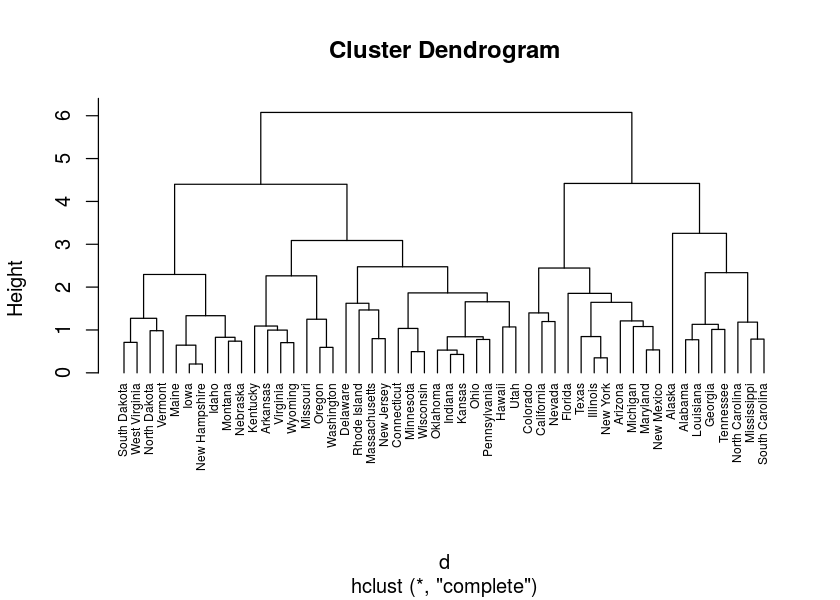

In [6]:
# Dissimilarity matrix
d <- dist(df, method = "euclidean")

# Hierarchical clustering using Complete Linkage
hc1 <- hclust(d, method = "complete" )

# Plot the obtained dendrogram
options(repr.plot.width=7, repr.plot.height=5)  # plot size
plot(hc1, cex = 0.6, hang = -1)

In [7]:
# Compute with agnes
hc2 <- agnes(df, method = "complete")

# Agglomerative coefficient
hc2$ac

[1] 0.8531583

关于`Agglomerative coefficient`:

With the agnes function you can also get the agglomerative coefficient, which measures the amount of clustering structure found (values closer to 1 suggest strong clustering structure).

This allows us to find certain hierarchical clustering methods that can identify stronger clustering structures. Here we see that Ward’s method identifies the strongest clustering structure of the four methods assessed.


In [12]:
# methods to assess
m <- c( "average", "single", "complete", "ward")
names(m) <- c( "average", "single", "complete", "ward")

# function to compute coefficient
ac <- function(x) {
  agnes(df, method = x)$ac
}
# map_dbl: map functions and return double vectors
map_dbl(m, ac)

average    single  complete      ward 
0.7379371 0.6276128 0.8531583 0.9346210

`ward`方法的`Agglomerative coefficient`最大， 效果最好。

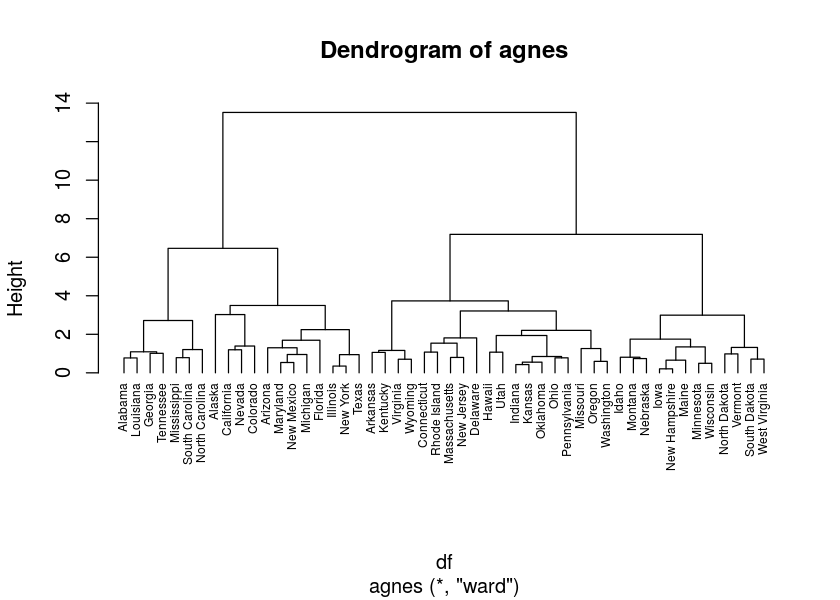

In [13]:
# 可视化
hc3 <- agnes(df, method = "ward")
pltree(hc3, cex = 0.6, hang = -1, main = "Dendrogram of agnes") 

#### Divisive Hierarchical Clustering

[1] 0.8514345

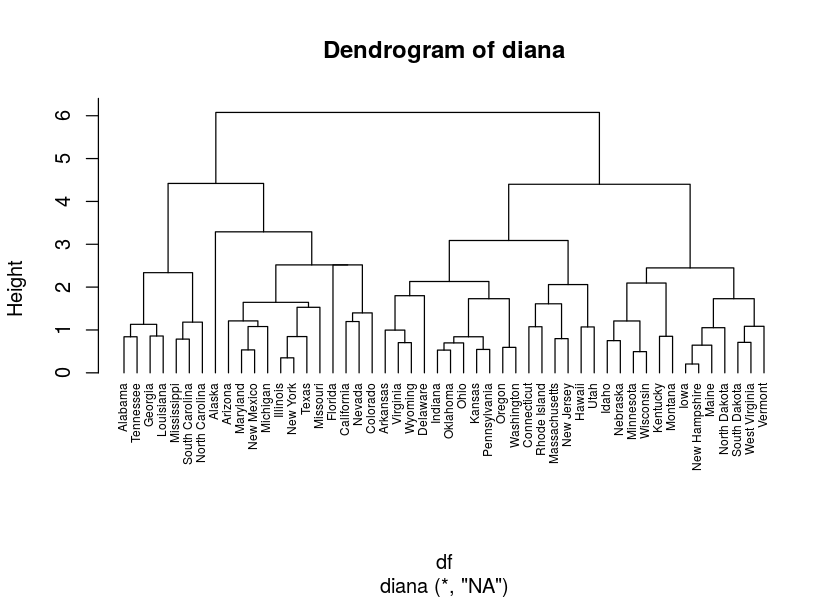

In [14]:
# compute divisive hierarchical clustering
hc4 <- diana(df)

# Divise coefficient; amount of clustering structure found
hc4$dc
## [1] 0.8514345

# plot dendrogram
pltree(hc4, cex = 0.6, hang = -1, main = "Dendrogram of diana")

关于系统树图有几点注意的地方：图的纵轴是各个case之间相似度的衡量，横轴仅仅只是每个case的标记，其距离无实际的意义。*Note that, conclusions about the proximity of two observations can be drawn only based on the height where branches containing those two observations first are fused. We cannot use the proximity of two observations along the horizontal axis as a criteria of their similarity.*

#### Working with Dendrograms

##### Cut the tree

In [15]:
# Ward's method
hc5 <- hclust(d, method = "ward.D2" )

# Cut tree into 4 groups
sub_grp <- cutree(hc5, k = 4)

# Number of members in each cluster
table(sub_grp)

sub_grp
 1  2  3  4 
 7 12 19 12 

In [16]:
USArrests %>%
  mutate(cluster = sub_grp) %>%
  head

Murder,Assault,UrbanPop,Rape,cluster
13.2,236,58,21.2,1
10.0,263,48,44.5,2
8.1,294,80,31.0,2
8.8,190,50,19.5,3
9.0,276,91,40.6,2
7.9,204,78,38.7,2


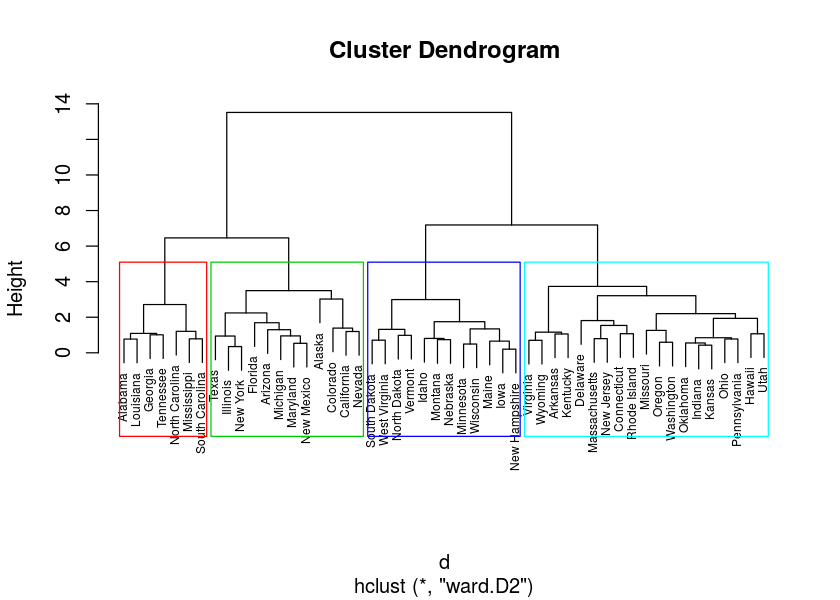

In [17]:
plot(hc5, cex = 0.6)
rect.hclust(hc5, k = 4, border = 2:5)

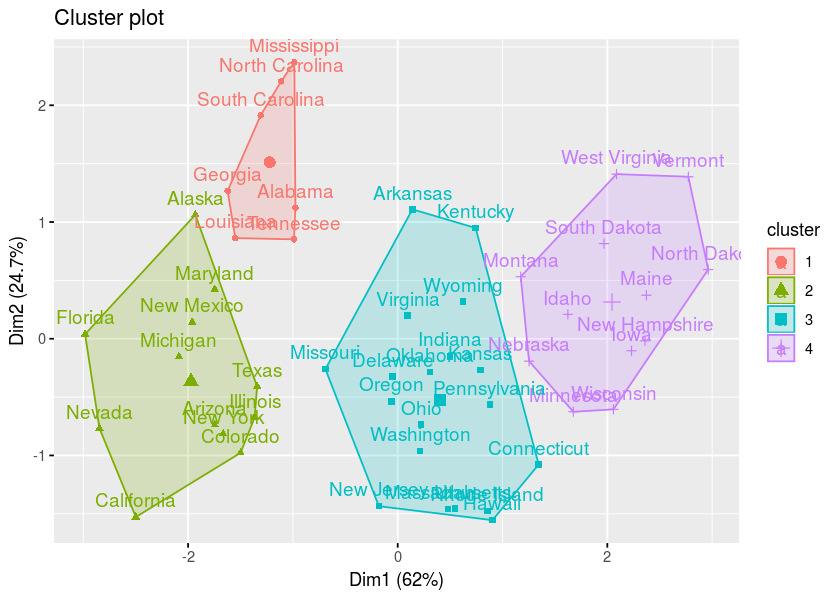

In [20]:
# visualize the result in a scatter plot
fviz_cluster(list(data = df, cluster = sub_grp))

To use `cutree` with `agnes` and `diana` you can perform the following:

In [22]:
# Cut agnes() tree into 4 groups
hc_a <- agnes(df, method = "ward")
cluster_a <- cutree(as.hclust(hc_a), k = 4)

# Cut diana() tree into 4 groups
hc_d <- diana(df)
cluster_d <- cutree(as.hclust(hc_d), k = 4)

##### Compare the tree

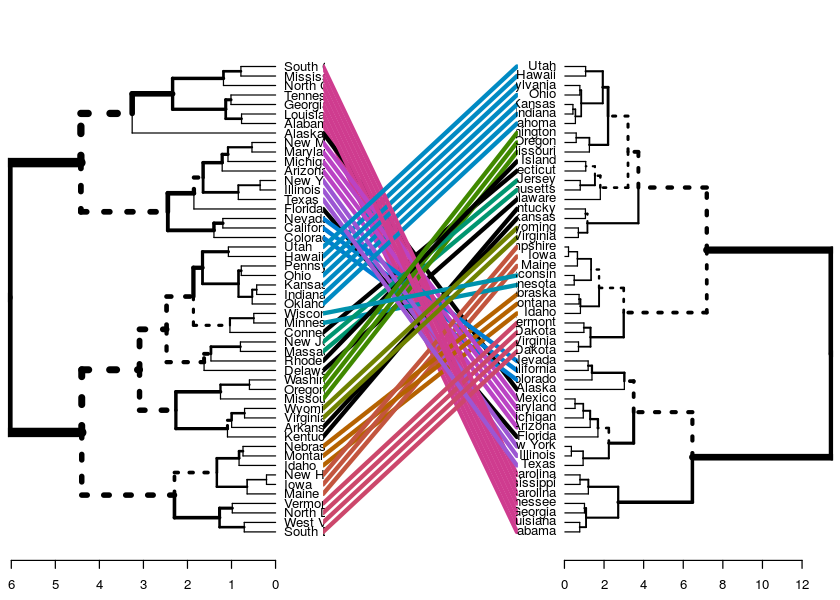

In [23]:
# Compute distance matrix
res.dist <- dist(df, method = "euclidean")

# Compute 2 hierarchical clusterings
hc1 <- hclust(res.dist, method = "complete")
hc2 <- hclust(res.dist, method = "ward.D2")

# Create two dendrograms
dend1 <- as.dendrogram (hc1)
dend2 <- as.dendrogram (hc2)

tanglegram(dend1, dend2)

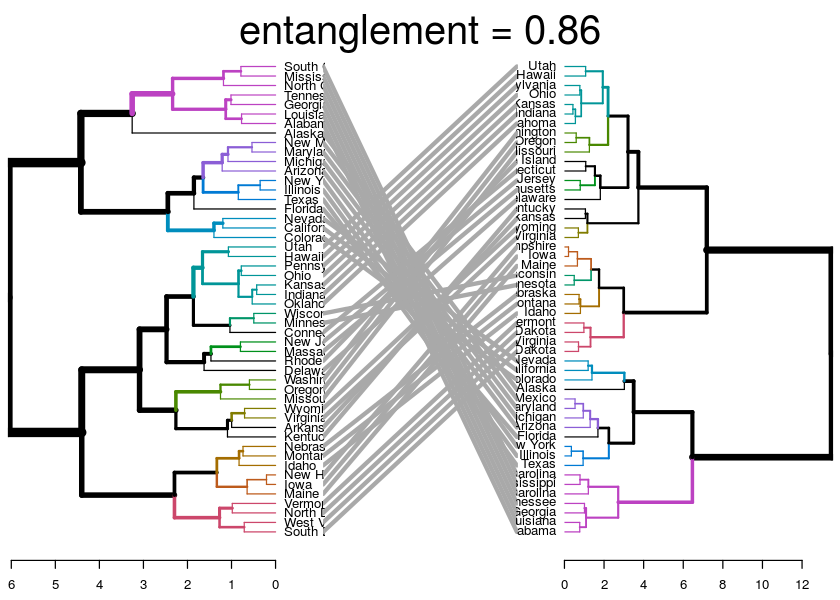

In [24]:
dend_list <- dendlist(dend1, dend2)

tanglegram(dend1, dend2,
  highlight_distinct_edges = FALSE, # Turn-off dashed lines
  common_subtrees_color_lines = FALSE, # Turn-off line colors
  common_subtrees_color_branches = TRUE, # Color common branches 
  main = paste("entanglement =", round(entanglement(dend_list), 2))
  )

`Entanglement` is a measure between 1 (full entanglement) and 0 (no entanglement). A lower entanglement coefficient corresponds to a good alignment. 

### Determining Optimal Clusters

#### Elbow Method

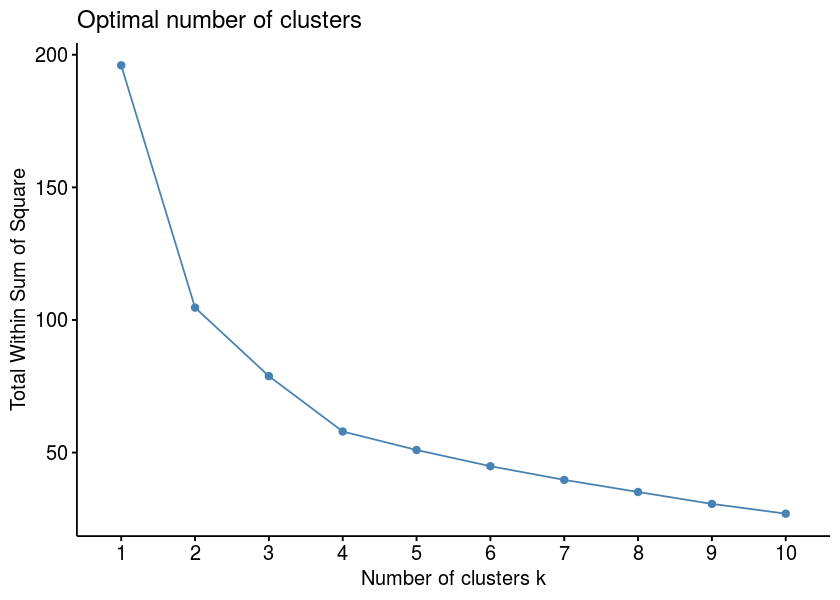

In [25]:
fviz_nbclust(df, FUN = hcut, method = "wss")

#### Average Silhouette Method
轮廓系数法

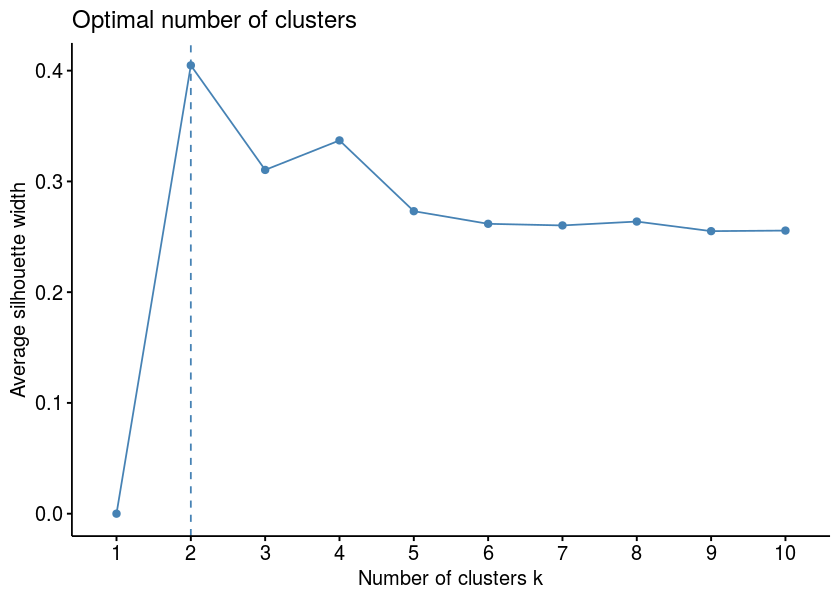

In [26]:
fviz_nbclust(df, FUN = hcut, method = "silhouette")

#### Gap Statistic Method

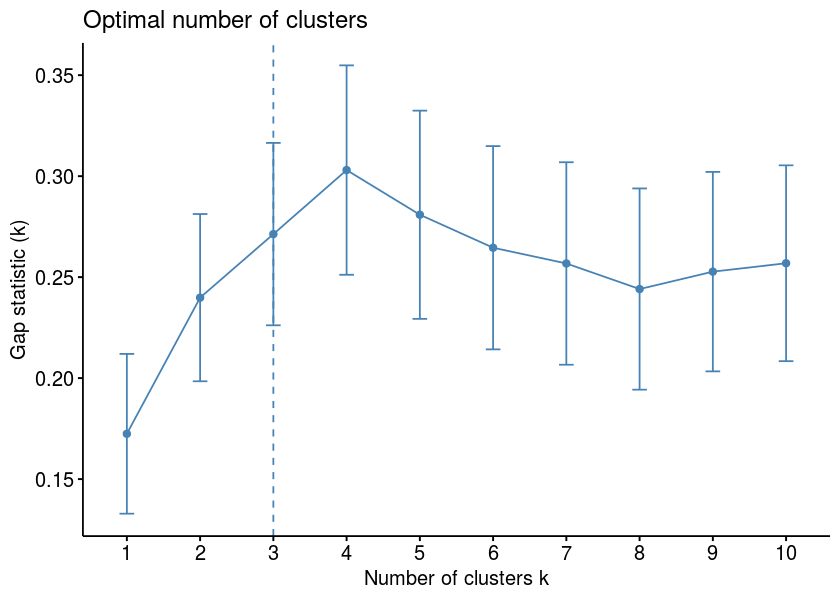

In [27]:
gap_stat <- clusGap(df, FUN = hcut, nstart = 25, K.max = 10, B = 50)
fviz_gap_stat(gap_stat)

#### Additional Comments

需要仔细考虑的三个问题：

    What dissimilarity measure should be used?
    What type of linkage should be used?
    Where should we cut the dendrogram in order to obtain clusters?
